In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import seaborn as sb

In [2]:
class ModifiedLabelEncoder(LabelEncoder):

    def fit_transform(self, y, *args, **kwargs):
        return super().fit_transform(y).reshape(-1, 1)

    def transform(self, y, *args, **kwargs):
        return super().transform(y).reshape(-1, 1)

In [3]:
%matplotlib inline

In [4]:
column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation',
                'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
                'class']
columns_num = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
columns_cat = ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country'] 
# dropped education as education-num is present

columns_corr_cat = ['marital-status', 'relationship', 'sex']
len(columns_num), len(columns_cat), len(column_names), len(columns_num) + len(columns_cat) 

(6, 7, 15, 13)

In [5]:
def load_data(directory, file_name, names=None, header=None, skiprows=0):
    return pd.read_csv(os.path.join(directory, file_name), names=names, header=header, skiprows=skiprows, skipinitialspace=True)

In [6]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [7]:
def scoring_using_cross_validation(m, x, y, s='accuracy'):
    print("************* Start of Cross Validation {} {} *************".format(s, m))
    scores_ = cross_val_score(m, x, y, scoring="accuracy", cv=10)
    rmse_scores_ = np.sqrt(scores_)
    display_scores(rmse_scores_)
    print("************* End of Cross Validation {} {}*************".format(s, m))


def print_scores(m, Y_test, Y_predictions):
    print("************* {} *************".format(m))
    mse_ = mean_squared_error(Y_test, Y_predictions)
    print("mse ", mse_)
    acc_ = accuracy_score(Y_test, Y_predictions)
    print("acc ", acc_)
    print("****************************************")


In [8]:
base_directory = '~/workspace/personal/datasets/income_predictions'

In [9]:
base_directory

'~/workspace/personal/datasets/income_predictions'

In [124]:
adult_data_df = load_data(base_directory, 'adult.data', column_names, None, 0)
adult_test_df = load_data(base_directory, 'adult.test', names=column_names, skiprows=1)

In [125]:
class ColumnDropperTransformer(TransformerMixin, BaseEstimator):
    def __init__(self, columns):
        self.columns = columns

    def transform(self, X, y=None):
        return X.drop(self.columns, axis=1)

    def fit(self, X, y=None):
        return self


class ColumnUnknownValueTransformer(TransformerMixin, BaseEstimator):
    def __init__(self, columns):
        self.columns = columns

    def transform(self, X, y=None):
        for c in self.columns:
            X[c].replace(['?'], 'unknown_{}'.format(c), inplace=True)
        return X

    def fit(self, X, y=None):
        return self



In [126]:
preprocess_pipeline = Pipeline([
        ('dropper', ColumnDropperTransformer(['education'])),
        ('unknown_value_replacer', ColumnUnknownValueTransformer(['workclass', 'occupation', 'native-country']))
    ])

adult_data_df = preprocess_pipeline.fit_transform(adult_data_df)
adult_test_df = preprocess_pipeline.fit_transform(adult_test_df)

# Correlation matrix between class and num columns

In [24]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split


# X_train, X_test, y_train, y_test = train_test_split(adult_data_df.drop('class', axis=1), adult_data_df['class'].copy())
# train_set = X_train.join(y_train)
# test_set = X_test.join(y_test)

split = ShuffleSplit(n_splits=20, test_size=0.25, random_state=42)
# train_index, test_index = list(split.split(adult_data_df[columns_num]))[0]

for train_index, test_index in list(split.split(adult_data_df[columns_num])):
    train_set = adult_data_df.loc[train_index]
    test_set = adult_data_df.loc[test_index]
    
print(train_set.shape, test_set.shape, train_set.shape[0] + test_set.shape[0])
print(adult_data_df.shape)
# print(adult_test_df.shape)
print(test_set.shape[0] / train_set.shape[0])

X1 = train_set[columns_num].join(train_set[columns_cat])
X2 = train_set[columns_num].join(train_set[columns_corr_cat])
print(X1.shape, len(columns_num + columns_cat))
print(X2.shape, len(columns_num + columns_corr_cat))

from sklearn.preprocessing import Normalizer
num_pipeline = Pipeline([
    ('std_scaler', StandardScaler()),
])

sparse=True

ct1 = ColumnTransformer([
    ("norm2", num_pipeline, columns_num),
    ("onehot", OneHotEncoder(), columns_cat)
])
ct2 = ColumnTransformer([
    ("norm2", num_pipeline, columns_num),
    ("onehot", OneHotEncoder(), columns_corr_cat)
])
X1_prepared = ct1.fit_transform(X1)
X2_prepared = ct2.fit_transform(X2)


Y_prepared = LabelEncoder().fit_transform(train_set['class'].copy())

X1_test = ct1.fit_transform(test_set[columns_num].join(test_set[columns_cat]))
X2_test = ct2.fit_transform(test_set[columns_num].join(test_set[columns_corr_cat]))
Y_test = LabelEncoder().fit_transform(test_set['class'].copy()) # Y1, Y2 both are same

print(X1_prepared.shape)
print(X2_prepared.shape)
print(Y_prepared.shape)
print(X1_test.shape)
print(X2_test.shape)

(24420, 15) (8141, 15) 32561
(32561, 15)
0.3333742833742834
(24420, 13) 13
(24420, 9) 9
(24420, 92)
(24420, 21)
(24420,)
(8141, 91)
(8141, 21)


In [25]:
def evaluate(x, y, x_test, y_test):
    global sgd, dt, rf
    sgd = SGDClassifier()
    sgd.fit(x, y)

    Y_predictions = sgd.predict(x_test)
    print_scores(sgd, y_test, Y_predictions)
    scoring_using_cross_validation(sgd, x, y, 'accuracy')
    scoring_using_cross_validation(sgd, x, y, 'neg_mean_squared_error')

    dt = DecisionTreeClassifier()
    dt.fit(x, y)
    Y_predictions = dt.predict(x_test)
    print_scores(dt, y_test, Y_predictions)
    scoring_using_cross_validation(dt, x, y, 'accuracy')
    scoring_using_cross_validation(dt, x, y, 'neg_mean_squared_error')

    rf = RandomForestClassifier()
    rf.fit(x, y)
    Y_predictions = rf.predict(x_test)
    print_scores(rf, y_test, Y_predictions)
    scoring_using_cross_validation(rf, x, y, 'accuracy')
    scoring_using_cross_validation(rf, x, y, 'neg_mean_squared_error')

In [26]:
evaluate(X2_prepared, Y_prepared, X2_test, Y_test)

************* SGDClassifier() *************
mse  0.1596855423166687
acc  0.8403144576833312
****************************************
************* Start of Cross Validation accuracy SGDClassifier() *************
Scores: [0.91979772 0.91309519 0.90904996 0.91689931 0.92224311 0.91868403
 0.91264661 0.91354356 0.92290891 0.92091007]
Mean: 0.9169778457852307
Standard deviation: 0.004446482567048741
************* End of Cross Validation accuracy SGDClassifier()*************
************* Start of Cross Validation neg_mean_squared_error SGDClassifier() *************
Scores: [0.9206877  0.90927517 0.91040037 0.91712259 0.92224311 0.91823817
 0.91242223 0.92313073 0.91734581 0.91846113]
Mean: 0.9169327015199251
Standard deviation: 0.0045455109297786195
************* End of Cross Validation neg_mean_squared_error SGDClassifier()*************
************* DecisionTreeClassifier() *************
mse  0.19334234123572042
acc  0.8066576587642795
****************************************
***********

In [44]:
from sklearn.metrics import precision_score, recall_score, f1_score

Y_predictions = sgd.predict(X2_test)
print(precision_score(Y_test, Y_predictions), recall_score(Y_test, Y_predictions), 
      f1_score(Y_test, Y_predictions))

0.7129798903107861 0.5852926463231616 0.6428571428571428


In [28]:
print(sgd.decision_function(X2_prepared[:10, :]))
print(Y_prepared[:10])

[-2.44689407 -0.92210013  0.40375021 -4.2864253  -2.99950063 -2.40077386
 -4.90554994 -0.80760358  2.66148875 -1.16560144]
[0 0 0 0 0 0 0 1 1 0]


In [60]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds): 
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision") 
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend(loc="center right")


(24266,)


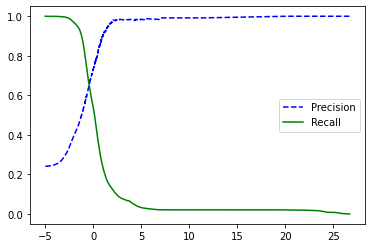

In [79]:
y_scores = cross_val_predict(sgd, X2_prepared, Y_prepared, cv=3, method="decision_function")
y_probas_forest = cross_val_predict(rf, X2_prepared, Y_prepared, cv=3, method="predict_proba")

from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(Y_prepared, y_scores)

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

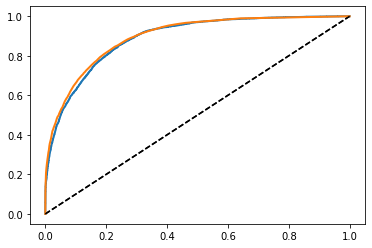

0.8884325122509649


In [77]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(Y_prepared, y_scores)
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(Y_prepared, y_scores_forest)

def plot_roc_curve(fpr, tpr, label=None): 
    plt.plot(fpr, tpr, linewidth=2, label=label) 
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal [...] # Add axis labels and grid
    
plot_roc_curve(fpr, tpr)
plot_roc_curve(fpr_forest, tpr_forest)

plt.show()

print(roc_auc_score(Y_prepared, y_scores))